## **Introduction**
Pittsburgh has many different neighborhoods, which can make it pretty hard when answering: *What is the best neighborhood in pittsburgh?* We answered this using 3 submetrics of which we chose depending on factors such as recency, effectiveness, and what we consider makes a "good" neighborhood. We came up with with our metric by analyzing different datasets including house value, criminal activity, and completed service requests. These three things together allowed us to define the best neighborhood as one with high performance in stability and safety. Essentially, we are looking for the neighborhood with high quality living conditions and resident wellbeing.

# The Best Neighborhood...
 ### offers the greatest quality, security, and stability.


Our Metric works on a point system from 0.1-1. The best performing city in that submetric will have 1 point while the worst performer will get a score of 0.1. This is then multiplied by 10 to get the score for that submetric. At the end, the neighborhood with the most points will be declared the **best neighborhood in Pittsburgh.**

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


1. ## Crime Activity / Safety

*Crime activity data can share information about a neighborhood's safety, however just the sheer number of crimes isn't enough for defining safety. Throughout my workflow I expanded on many possible routes before deciding that safety should be a measure of crime count rates and severity.*

In [108]:
import warnings

warnings.filterwarnings('ignore')
##Creating the datasets I will need for my safety submetric
crim_data = pd.read_csv('criminalactivity.csv')
crim = crim_data[['ReportedDate', 'ReportedMonth', 'NIBRS_Offense_Type', 'NIBRS_Offense_Grouping', 'Zone', 'Neighborhood']]
pop_data = pd.read_csv('pop.csv')
pop = pop_data[['Neighborhood', '2020_Total_Population']]

pop['Neighborhood'] = pop['Neighborhood'].str.replace('Arlington - Arlington Heights (Combined)', 'Arlington')
crim['Neighborhood'] = crim['Neighborhood'].str.replace('Saint Clair', 'St. Clair')
crim['Neighborhood'] = crim['Neighborhood'].str.replace('Mount Oliver', 'Mt. Oliver')
crim['Neighborhood'] = crim['Neighborhood'].replace('Arlington Heights', 'Arlington')
crim['Neighborhood'] = crim['Neighborhood'].replace('Chartiers', 'Chartiers City')

valid_neighs = pop['Neighborhood'].unique()
crim = crim[crim['Neighborhood'].isin(valid_neighs)]

crim = crim.merge(pop, on='Neighborhood', how='left')
crime_counts = crim.groupby('Neighborhood').size().reset_index(name='Crime_Count')
neigh_rates = crime_counts.merge(pop, on='Neighborhood', how='left')
neigh_rates['Crime_Rate'] = neigh_rates['Crime_Count'] / neigh_rates['2020_Total_Population']

severity = crim.groupby(['Neighborhood', 'NIBRS_Offense_Grouping']).size().unstack(fill_value=0)

severity = severity.rename(columns={'A': 'A_Crimes', 'B': 'B_Crimes'})
neigh_full = neigh_rates.merge(severity, on='Neighborhood', how='left')



This code block above allows us to use data from the criminal activity and population dataset. The criminal activity data was then organized and merged with population, changing the neighborhood names to match. Crime severity was then parsed and added to the data referencing group A and group B. Group A crimes are considered more "severe" including violations such as assault, arson, and drug trafficking.

In [109]:
neigh_full['rank_rate'] = neigh_full['Crime_Rate'].rank()
neigh_full['rank_A'] = neigh_full['A_Crimes'].rank()
neigh_full['rank_total'] = neigh_full['Crime_Count'].rank()

neigh_full['Safety_Score'] = neigh_full[['rank_rate','rank_A','rank_total']].mean(axis=1)

Once all the data we need is gathered, we rank it to find the "safety score" of each neighborhood based on crime count rate, the amount of "severe" crimes, and the amount of crimes.

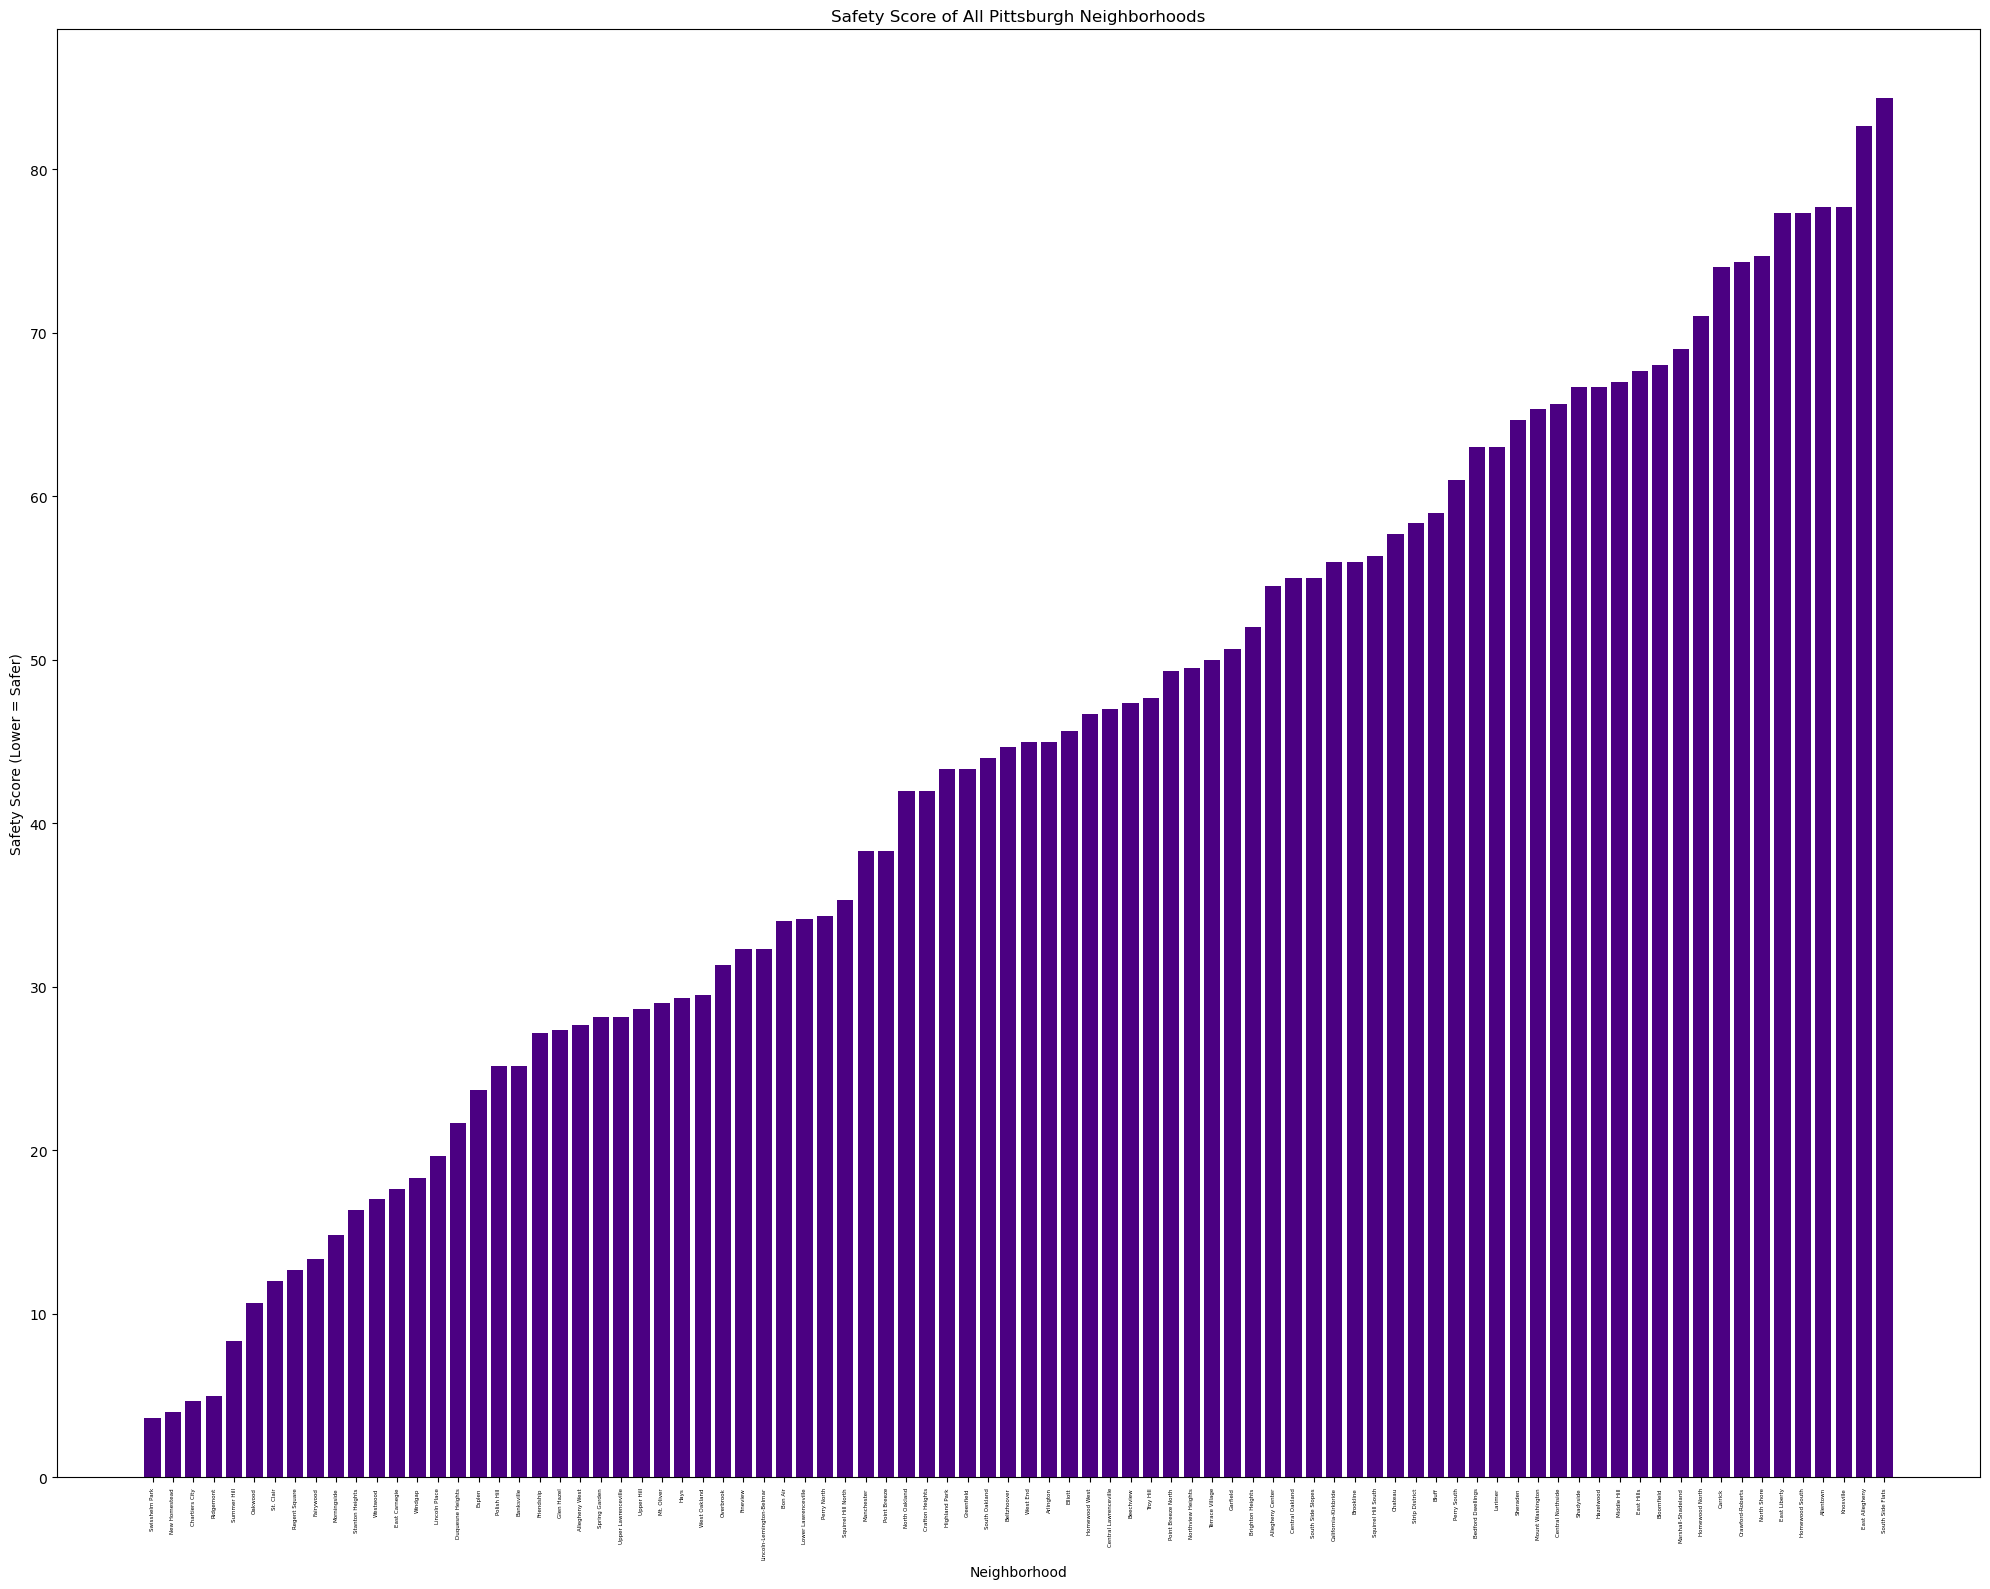

In [110]:

safety = neigh_full.sort_values('Safety_Score', ascending=True)

plt.figure(figsize=(20, 16))
plt.bar(safety['Neighborhood'], safety['Safety_Score'], color ="indigo")

plt.xticks(rotation=90, fontsize=4)  # small font so all labels fit
plt.xlabel("Neighborhood")
plt.ylabel("Safety Score (Lower = Safer)")
plt.title("Safety Score of All Pittsburgh Neighborhoods")

plt.tight_layout()
plt.show()

This bar graph is a demonstration of the data used to get a "safety" score for each Neighborhood. This submetric has its own submetrics, which are then ranked to get the safety score of each neighborhood, with the **lower** safety scores being a **higher** ranking, thus lower safety score = safer.

Here's a look at the top 20 within this submetric

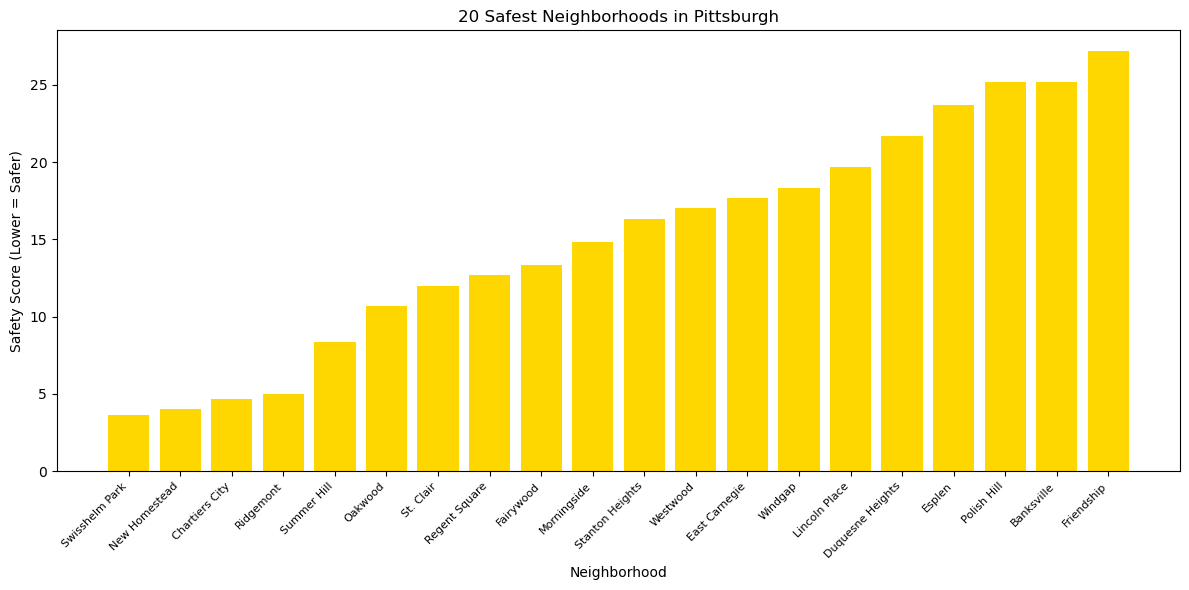

In [111]:
safety = neigh_full.sort_values('Safety_Score', ascending=True)

# Select the 20 safest
safest20 = safety.head(20)

plt.figure(figsize=(12, 6))
plt.bar(safest20['Neighborhood'], safest20['Safety_Score'], color="gold")

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel("Neighborhood")
plt.ylabel("Safety Score (Lower = Safer)")
plt.title("20 Safest Neighborhoods in Pittsburgh")

plt.tight_layout()
plt.show()

**Currently, this would put Swisshelm in first place with a total metric score of 10. The runners up are New Homestead and Chartiers City.**

### Top Scores in Crime Safety

In [112]:
safety_sorted = neigh_full.sort_values('Safety_Score', ascending=True).reset_index(drop=True)

n = len(safety_sorted)
safety_sorted['Score'] = 1 - (np.arange(n) / (n - 1)) * (1 - 0.1)

submetric1 = safety_sorted[['Neighborhood', 'Score']]
submetric1.head(10)

,Neighborhood,Score
0,Swisshelm Park,1.000000
1,New Homestead,0.989412
2,Chartiers City,0.978824
3,Ridgemont,0.968235
4,Summer Hill,0.957647
5,Oakwood,0.947059
6,St. Clair,0.936471
7,Regent Square,0.925882
8,Fairywood,0.915294
9,Morningside,0.904706


*Now that submetric 1 is complete, this can form a base for the metric we're using to get the best neighborhood. This code creates the dataset we'll use to store totals. Provided is also the top 10 in another format showing the totals.*

In [113]:
best_neighborhood = submetric1.copy()
best_neighborhood['Total'] = best_neighborhood['Score'] * 10

# Sort by the new metric descending and show top 10
top10 = best_neighborhood.sort_values('Total', ascending=False).head(10)

print(top10[['Neighborhood', 'Total']])

     Neighborhood      Total
0  Swisshelm Park  10.000000
1   New Homestead   9.894118
2  Chartiers City   9.788235
3       Ridgemont   9.682353
4     Summer Hill   9.576471
5         Oakwood   9.470588
6       St. Clair   9.364706
7   Regent Square   9.258824
8       Fairywood   9.152941
9     Morningside   9.047059


2. ## House Value

*House value can reveal the demand to live in a particular area. When a neighborhood is desirable, more people compete for homes there. This increased want and demand pushes home values higher. However, when fewer people want to live in a neighborhood, home values typically fall because of the lack of competition. The neighborhood snapshot data allows us to compare much information about a neighborhood, but house value and the change in house value can be a good indicator of what neighborhoods are thriving in stability.

In [114]:
PGH_Neighborhoods_Snap = pd.read_csv ( 'PGH_Neighborhoods_SNAP.csv' )
snap = PGH_Neighborhoods_Snap[['Neighborhood','Median Home  Value (2010)', 'Median Home Value (2000)' , '% Change Real Value 2000-2010']]

# Load the CSV
PGH_Neighborhoods_Snap = pd.read_csv('PGH_Neighborhoods_SNAP.csv')

# Create a clean dataset with selected columns
snap = PGH_Neighborhoods_Snap[
    [
        'Neighborhood',
        'Median Home  Value (2010)',
        'Median Home Value (2000)',
        '% Change Real Value 2000-2010'
    ]
]
snap = snap[snap['Neighborhood'].isin(valid_neighs)]
snap.head()

,Neighborhood,Median Home Value (2010),Median Home Value (2000),% Change Real Value 2000-2010
0,Central Oakland,"$144,350","$62,100",83.6%
1,North Oakland,"$273,000","$222,423",-3.1%
2,West Oakland,"$61,100","$47,500",1.6%
3,Crawford-Roberts,"$94,600","$70,800",5.5%
4,Strip District,"$161,800","$215,900",-40.8%


This data allows us to see the Neighborhood, Home Value in 2000 and 2010 and the change in real value. The most important pieces are median home value (2010) and % change real value in those 10 years.

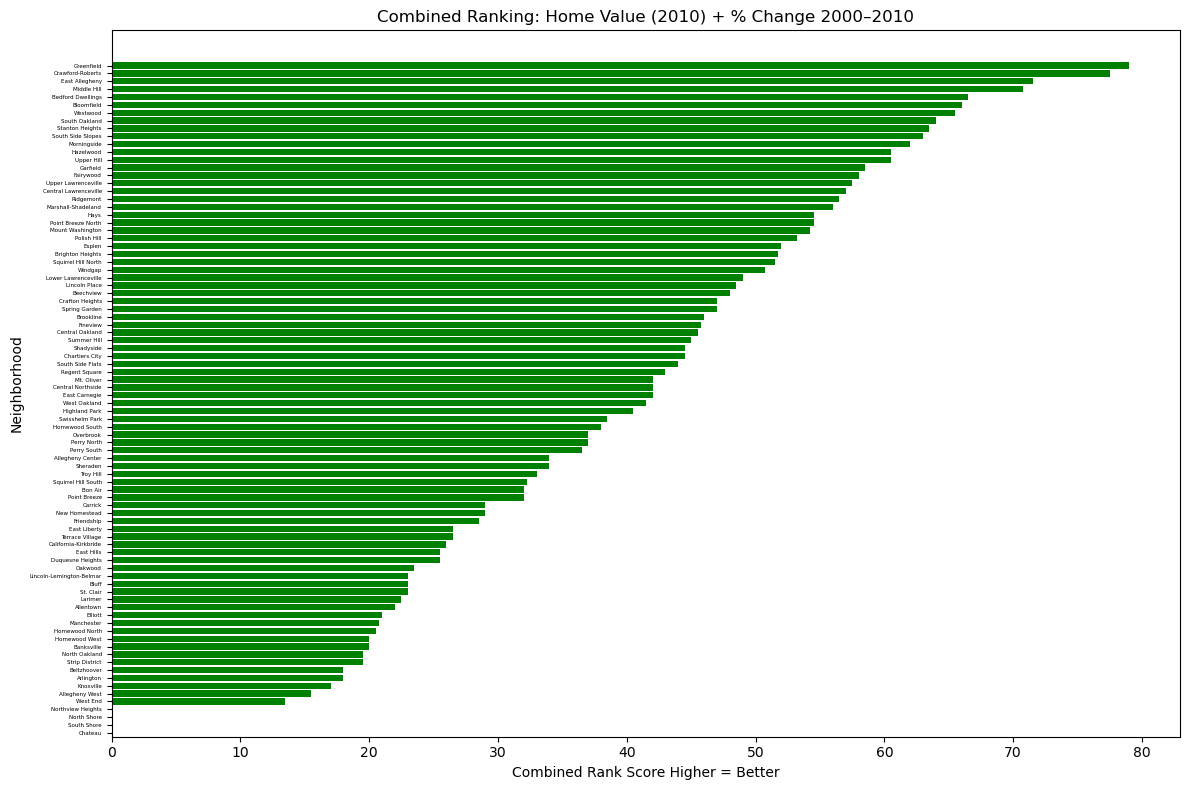

In [115]:
snap['rank_2010'] = snap['Median Home  Value (2010)'].rank(ascending=True)
snap['rank_change'] = snap['% Change Real Value 2000-2010'].rank(ascending=True)

snap['combined_rank'] = snap[['rank_2010', 'rank_change']].mean(axis=1)

snap_sorted = snap.sort_values('combined_rank', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(
    snap_sorted['Neighborhood'],
    snap_sorted['combined_rank'],
    color = "green"
)

plt.gca().invert_yaxis()

plt.yticks(fontsize=4)
plt.title('Combined Ranking: Home Value (2010) + % Change 2000–2010')
plt.xlabel('Combined Rank Score Higher = Better')
plt.ylabel('Neighborhood')

plt.tight_layout()
plt.show()

This graph also uses a rank system. These rankings compare median house value and % change in real value to find the best neighborhoods in this submetric. Higher house value is great, but we want to see that has been maintained over the course of those 10 years which is why we combine the two.

The top 20 of this submetric:

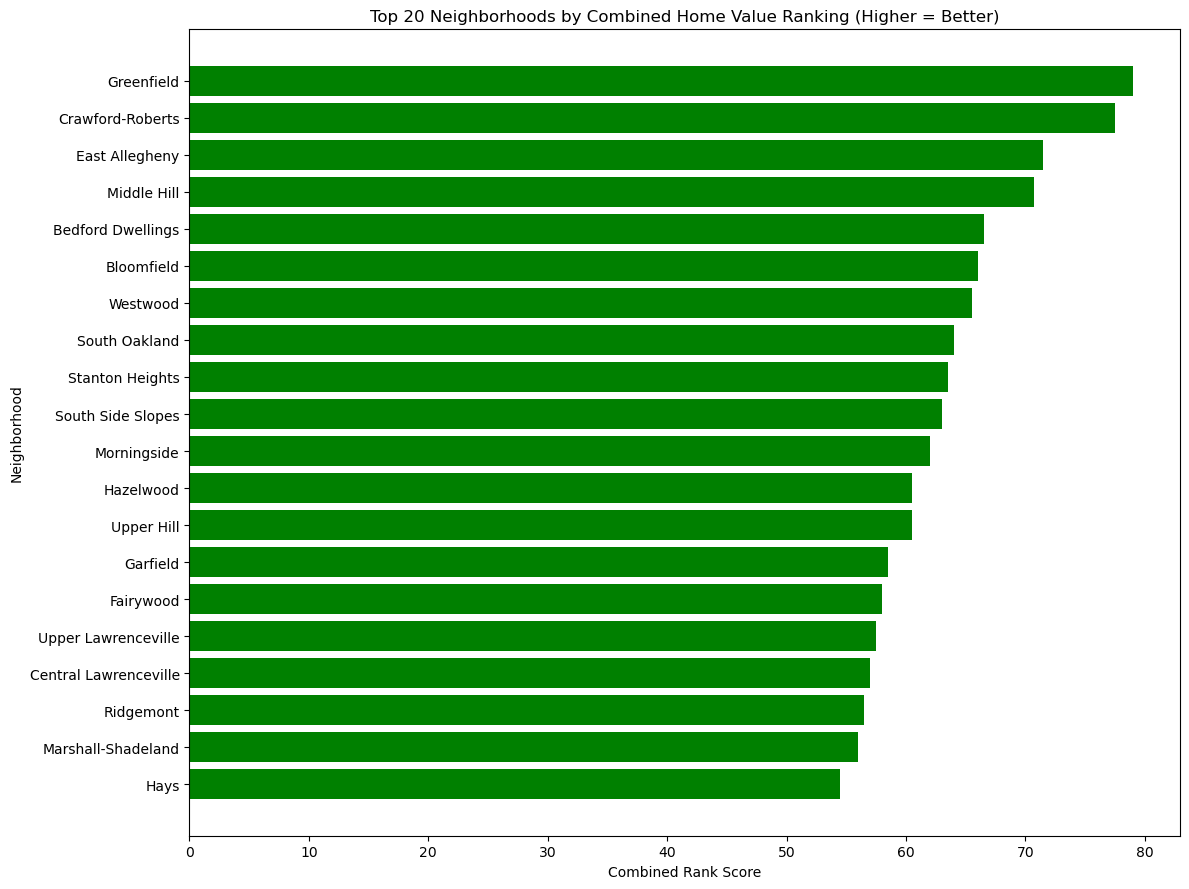

In [116]:
top20 = snap.sort_values('combined_rank', ascending=False).head(20)

# --- Plot (all green bars) ---
plt.figure(figsize=(12, 9))
plt.barh(
    top20['Neighborhood'],
    top20['combined_rank'],
    color='green'
)

plt.title('Top 20 Neighborhoods by Combined Home Value Ranking (Higher = Better)')
plt.xlabel('Combined Rank Score')
plt.ylabel('Neighborhood')

# Best at top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

This gives us the top 20 rankings for the house value + % change in descending order. For this submetric, Greenfield comes in first with the runner ups being Crawford-Roberts and East Allegheny.

In [117]:
best_sort = snap.sort_values('combined_rank', ascending=False).reset_index(drop=True)

n = len(best_sort)
best_sort['combined_rank'] = 1 - (np.arange(n) / (n - 1)) * (1 - 0.1)

submetric2 = best_sort[['Neighborhood', 'combined_rank']]
submetric2.head(10)

,Neighborhood,combined_rank
0,Greenfield,1.000000
1,Crawford-Roberts,0.989535
2,East Allegheny,0.979070
3,Middle Hill,0.968605
4,Bedford Dwellings,0.958140
5,Bloomfield,0.947674
6,Westwood,0.937209
7,South Oakland,0.926744
8,Stanton Heights,0.916279
9,South Side Slopes,0.905814


In [118]:
temp = submetric2.set_index('Neighborhood')['combined_rank'] * 10
if 'Neighborhood' in best_neighborhood.columns:
    best_neighborhood = best_neighborhood.set_index('Neighborhood')

best_neighborhood['Total'] = best_neighborhood['Total'] + temp
best_neighborhood['Score'] = submetric2.set_index('Neighborhood')['combined_rank']

top10 = best_neighborhood.sort_values('Total', ascending=False).head(10)

print(top10[['Total']])

                         Total
Neighborhood                  
Westwood             18.207387
Stanton Heights      18.103967
Morningside          18.000547
Ridgemont            17.903283
Fairywood            17.687825
Upper Hill           16.203010
Upper Lawrenceville  15.994938
Chartiers City       15.916142
Summer Hill          15.913680
Windgap              15.902599



Adding this submetric, Swisshelm Park falls out of first place with a way lower score this time around. The current favorite, thanks to the first two submetrics, is now Westwood, followed by Stanton Heights and Morningside.

In [119]:
neigh = "Swisshelm Park"

print(best_neighborhood.loc[[neigh]])

                  Score      Total
Neighborhood                      
Swisshelm Park  0.52907  15.290698


3. ## Completed Service Requests

*Completed service requests show that a neighborhood has active residents and responsive services, representing a well-maintained and cared-for community. The 311 Service Requests dataset contains over 800,000 reports of service issues across Pittsburgh, making it a valuable indicator of community needs, infrastructure problems, and local government responsiveness.*

In [120]:


url_311 = "https://tools.wprdc.org/downstream/29462525-62a6-45bf-9b5e-ad2e1c06348d"
data311 = pd.read_csv(url_311, chunksize=50000, low_memory=False)
data311 = data311[data311['neighborhood'].isin(valid_neighs)]

TypeError: 'TextFileReader' object is not subscriptable

In [121]:
# Clean 311 data

date_col = "create_date_et"
neighborhood_col = "neighborhood"

# keep only necessary columns
work_311 = data311[[date_col, neighborhood_col]].copy()

# convert date column to datetime
work_311[date_col] = pd.to_datetime(work_311[date_col], errors="coerce")

# drop rows missing date or neighborhood
work_311 = work_311.dropna(subset=[date_col, neighborhood_col])

# standardize neighborhood names
work_311[neighborhood_col] = work_311[neighborhood_col].str.strip().str.title()

print("Rows after clean:", len(work_311))
work_311.head()

TypeError: 'TextFileReader' object is not subscriptable

In [122]:
latest_date = work_311[date_col].max()
cutoff_date = latest_date - pd.DateOffset(years=3)

recent_311 = work_311[work_311[date_col] >= cutoff_date].copy()
print("Rows in last 3 years:", len(recent_311))

Rows in last 3 years: 251698


In [123]:
counts = (
    recent_311
    .groupby(neighborhood_col)[date_col]
    .count()
    .sort_values(ascending=False)
)

counts.head(10)

neighborhood
South Side Flats       12558
South Side Slopes      10803
Squirrel Hill South    10491
Brookline              10122
Carrick                 9355
Bloomfield              8271
Crafton Heights         7120
Mount Washington        6822
Shadyside               6482
Beechview               6252
Name: create_date_et, dtype: int64

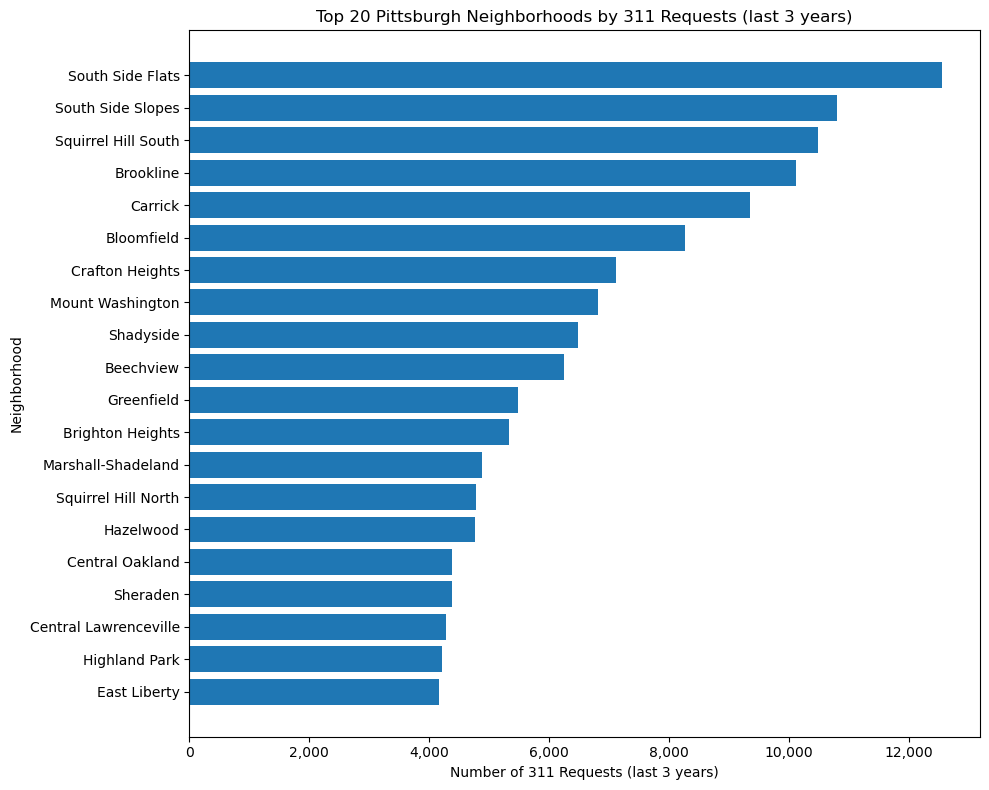

In [124]:
# plot top 10 neighborhoods by request count
top_counts = counts.head(20)[::-1]
# reverse for horizontal bar chart ^

fig, ax = plt.subplots(figsize=(10, 8))

ax.barh(top_counts.index, top_counts.values)

ax.set_xlabel("Number of 311 Requests (last 3 years)")
ax.set_ylabel("Neighborhood")
ax.set_title(f"Top 20 Pittsburgh Neighborhoods by 311 Requests (last 3 years)")

# Optional: format x-axis with thousands separator
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

plt.tight_layout()
plt.show()

In [ ]:
This data allows us to see the number of 311 requests in a recency 

In [125]:
recent_counts = recent_311.groupby('neighborhood').size().reset_index(name='recent_311_count')

sorted311 = recent_counts.sort_values('recent_311_count', ascending=False).reset_index(drop=True)

# Ranking — higher count = higher score
n = len(sorted311)
sorted311['Score'] = 1 - (np.arange(n) / (n - 1)) * (1 - 0.1)

submetric3 = sorted311[['neighborhood', 'Score']]
submetric3.head(10)

,neighborhood,Score
0,South Side Flats,1.000000
1,South Side Slopes,0.989535
2,Squirrel Hill South,0.979070
3,Brookline,0.968605
4,Carrick,0.958140
5,Bloomfield,0.947674
6,Crafton Heights,0.937209
7,Mount Washington,0.926744
8,Shadyside,0.916279
9,Beechview,0.905814


In [126]:
temp = submetric3.set_index('neighborhood')['Score'] * 10
if 'Neighborhood' in best_neighborhood.columns:
    best_neighborhood = best_neighborhood.set_index('Neighborhood')

best_neighborhood['Total'] = best_neighborhood['Total'] + temp
best_neighborhood['Score'] = submetric3.set_index('neighborhood')['Score']

top10 = best_neighborhood.sort_values('Total', ascending=False).head(10)

print(top10[['Total']])

                           Total
Neighborhood                    
Stanton Heights        25.906293
Greenfield             24.718194
Morningside            24.023803
South Side Slopes      22.918194
South Oakland          22.833242
Westwood               22.451573
Squirrel Hill North    22.423256
Crafton Heights        22.209029
Upper Lawrenceville    21.599590
Central Lawrenceville  21.570041


# Conclusion

1. ## Stanton Heights 25.91
2. ### Greenfield 24.72
3. #### Morningside 24.03

### After a long fought battle, Stanton Heights comes out on top as the **BEST** neighborhood in Pittsburgh. 

In [127]:
submetric1 = submetric1.set_index('Neighborhood')

In [128]:
submetric1 = submetric1.set_index('Neighborhood')

neigh = "Stanton Heights"
print(submetric1.loc[neigh])

KeyError: "None of ['Neighborhood'] are in the columns"

Stanton Heights has been declared the best neighborhood in Pittsburgh. It has done pretty well in all three areas, seeing a big climb during the second submetric of house value and % change after 10 years. With the x10 bonus, Stanton Heights scored **8.9411** in Crime Activity (Safety), **9.16279** in House Value + % Change, and **7.80233** in 311 Service requests for a total of 25.906293/30 and an average score of .863 per round (8.63 with multiplier). Altogether, this balance of safety, rising home values, and efficient city service responsiveness showcases Stanton Heights as a well-rounded, thriving, and highly desirable neighborhood—earning the title of Pittsburgh’s best with both data-driven strength and long-term promise.